In [17]:
import numpy as np
import matplotlib.pyplot
import mnist
import scipy
import scipy.sparse.linalg
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import pdb


In [18]:
trainX, trainY = mnist.load_mnist("training", None, './MNIST');
testX, testY = mnist.load_mnist("testing", None, './MNIST');
print("MNIST loaded")

MNIST loaded


In [19]:
#trainX = trainX[0:100, :]
#trainY = trainY[0:100]

In [20]:
class logistic:
    
    
    def __init__(self, eta, lamda, thresh):
        self.eta = eta;
        self.lamda = lamda;
        self.thresh = thresh;
        self.regularized = True;
        self.lossSet = np.zeros(2000);
        self.testLossSet = np.zeros(2000);
        
    def load_data(self, string, ori_X, ori_Y):
        """
        if string is "training":
            ori_X, self.Y = mnist.load_mnist("training", None, './MNIST');
        elif string is "testing":
            ori_X, self.Y = mnist.load_mnist("testing", None, './MNIST');
        """
        self.Y = ori_Y;
        s = ori_X.shape;
        self.d = s[1] * s[2] + 1;
        self.n = self.d;
        self.N = s[0];
        self.X = np.reshape(ori_X, (self.N, self.d-1));
        self.X = np.insert(self.X, 0, 1, axis=1);
        self.X_sparse = csr_matrix(self.X, shape=(self.N, self.d))
        print("Loading data " + string + " complete....")
        
    def load_test(self, testX, testY):
        self.testN = testX.shape[0];
        self.testX = np.reshape(testX, (self.testN, self.d-1));
        self.testX = np.insert(self.testX, 0, 1, axis=1);
        self.testY = testY
        
    def makeTestY(self, val):
        temp = np.array(self.testY == val, dtype=float);
        self.testY = np.reshape(temp, (self.testN, 1))
        print("Only looking at class " + str(val) + "!!!")
        
    def makeY(self, val):
        temp = np.array(self.Y == val, dtype=float);
        self.Y = np.reshape(temp, (self.N, 1))
        self.Y_sparse = csr_matrix(self.Y, shape=(self.N, 1))
        print("Testing Data : Only looking at class " + str(val) + "!!!")
    
    def initIteration(self):
        self.weights = np.zeros((self.n,1), dtype=float);
        self.iter = 0;
        self.prevLoss = 999999;
        self.weightDist = 99999;
    
    def computeTestLoss(self):
        temp = np.dot(self.testX, self.weights);
        temp[temp>100] = 100
        temp = np.exp(temp);
        self.prob1Test = temp / (1 + temp)
        self.sampleTestLoss = self.testY - self.prob1Test; 
        lttemp = np.concatenate([np.float64(self.testY==0), np.float64(self.testY==1)], axis=1);
        rttemp = np.asarray(np.concatenate([1-self.prob1Test, self.prob1Test], axis=1))
        self.testLoss = -np.sum(np.log(np.sum(lttemp * rttemp, axis=1) + 0.0000001)) / self.testN + self.lamda * np.linalg.norm(self.weights); 
        self.testLossSet[self.iter]=self.testLoss
    
    def computeProb1(self):
        temp = np.dot(self.X, self.weights);
        temp[temp>100] = 100
        temp = np.exp(temp);
        self.prob1 = temp / (1 + temp)
        self.sampleLoss = self.Y - self.prob1; 
        
    def computeLoss(self):
        
        #self.loss = np.sqrt(np.sum(self.sampleLoss * self.sampleLoss) / self.N)
        lttemp = np.concatenate([np.float64(self.Y==0), np.float64(self.Y==1)], axis=1);
        rttemp = np.asarray(np.concatenate([1-self.prob1, self.prob1], axis=1))
        self.loss = -np.sum(np.log(np.sum(lttemp * rttemp, axis=1) + 0.0000001)) / self.N + self.lamda * np.linalg.norm(self.weights); 
        self.lossSet[self.iter]=self.loss
    
    def updateWeights(self, curIdx, batchSize):
        #print('Weight ' + str(curIdx) + ' : ' + str(self.weights[curIdx]))
        self.batchSize = batchSize;
        idx_from = range(0, self.N, self.batchSize)
        idx_to = idx_from[1:]
        idx_to.extend([self.N])
        
        if self.regularized:
            for x in range(0, len(idx_from)):
                self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[idx_from[x]:idx_to[x], curIdx] * self.sampleLoss[idx_from[x]:idx_to[x],0]);
            self.weights[curIdx] = self.weights[curIdx] - self.eta * self.weights[curIdx] * self.lamda;
            #self.weights[curIdx] = self.weights[curIdx] + self.eta * (np.sum(self.X[:, curIdx] * self.sampleLoss[:,0]) - self.weights[curIdx] * self.lamda);
        else:
            for x in range(0, len(idx_from)):
                self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[idx_from[x]:idx_to[x], curIdx] * self.sampleLoss[idx_from[x]:idx_to[x],0]);
            #self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[:, curIdx] * self.sampleLoss[:,0]);
        #print('Weight ' + str(curIdx) + ' : ' + str(self.weights[curIdx]))
        
    def updateWeightsWhole(self, batchSize):
        self.batchSize = batchSize;
        idx_from = range(0, self.N, self.batchSize)
        idx_to = idx_from[1:]
        idx_to.extend([self.N])
        
        if self.regularized:
            #for x in range(0, len(idx_from)):
            #    self.weights = self.weights + self.eta * np.asmatrix(self.X[idx_from[x]:idx_to[x], :].transpose()) * np.asmatrix(self.sampleLoss[idx_from[x]:idx_to[x],:]) / (self.N);
            #pdb.set_trace();
            self.weights = self.weights + self.eta * np.asmatrix(self.X.transpose()) * np.asmatrix(self.sampleLoss) / (self.N);
            self.weights = self.weights - self.eta * self.weights * self.lamda;
            #self.weights = self.weights - self.eta * np.linalg.norm(self.weights[1:self.n]) * self.lamda;
            #self.weights[curIdx] = self.weights[curIdx] + self.eta * (np.sum(self.X[:, curIdx] * self.sampleLoss[:,0]) - self.weights[curIdx] * self.lamda);
        else:
            for x in range(0, len(idx_from)):
                self.weights = self.weights + self.eta * np.asmatrix(self.X[idx_from[x]:idx_to[x], :].transpose()) * self.sampleLoss[idx_from[x]:idx_to[x],:];
            #self.weights[curIdx] = self.weights[curIdx] + self.eta * np.sum(self.X[:, curIdx] * self.sampleLoss[:,0]);
        #print('Weight ' + str(curIdx) + ' : ' + str(self.weights[curIdx]))
    
    
    def distWeight(self, A, B):
        self.weightDist = scipy.linalg.norm(A - B);
        
        print("weight distance : " + str(self.weightDist));
    
    def updateWeightStochastic(self, curIdx, curSmp):
        if self.regularized:
            self.weights[curIdx] = self.weights[curIdx] + self.eta * (self.X[curSmp, curIdx] * self.sampleLoss[curSmp,0] - self.weights[curIdx] * self.lamda);
        else:
            self.weights[curIdx] = self.weights[curIdx] + self.eta * self.X[curSmp, curIdx] * self.sampleLoss[curSmp,0];
    
    def assess(self):
        self.computeProb1();
        self.pred = self.prob1 > 0.5;
        self.correct = np.sum(np.int16(self.pred == (self.Y==1)))
        self.overallAccu = np.float(self.correct) / np.float(self.N);
        self.loss01 = sum(abs(self.pred - self.Y)) / self.N
        print('Accuracy : ' + str(self.overallAccu))
        print('0 / 1 loss : ' + str(self.loss01))
    
    def genGaussFeatWeight(self, n):
        self.n = n;
        self.weight = np.random.randn(self.d, self.n);
    
    def randGaussFeatConv(self):
        self.X = np.dot(self.X, self.weight);
        
    def plotLoss(self, labelTrain, labelTest, name):
        %matplotlib inline 
        matplotlib.pyplot.plot(np.arange(0, model.iter), model.testLossSet[0:model.iter], hold = True, color="blue", linewidth=2.0)
        matplotlib.pyplot.plot(np.arange(0, model.iter), model.lossSet[0:model.iter], hold = True, color="red", linewidth=2.0)
        matplotlib.pyplot.savefig(name, transparent = True)

In [24]:
model = logistic(0.1, 0.01, 0.00001);
model.load_data("training", trainX, trainY);
model.load_test(testX, testY)
model.makeY(2);
model.makeTestY(2);

Loading data training complete....
Testing Data : Only looking at class 2!!!
Only looking at class 2!!!


In [25]:
model.initIteration();
model.computeProb1();
model.computeLoss();
model.computeTestLoss()
print ('Iteration 0 : Loss value ' + str(model.loss))


#while (model.weightDist > 0.01 or model.iter<3):
while (model.prevLoss - model.loss > model.thresh or model.iter<10):
    model.prevLoss = model.loss;
    model.iter = model.iter + 1;
    temp = model.weights.copy();
    
    model.updateWeightsWhole(500)
    model.computeProb1();
        
    model.computeLoss()
    model.computeTestLoss()
    model.distWeight(temp, model.weights)
    print ('Iteration ' + str(model.iter) + ' : Loss value ' + str(model.loss))

Iteration 0 : Loss value 0.69314698056
weight distance : 0.237977236008
Iteration 1 : Loss value 0.37356346001
weight distance : 0.0558246394994
Iteration 2 : Loss value 0.348425577372
weight distance : 0.0380122870115
Iteration 3 : Loss value 0.335502204165
weight distance : 0.0319848496934
Iteration 4 : Loss value 0.325890323568
weight distance : 0.029365456615
Iteration 5 : Loss value 0.317613636821
weight distance : 0.0279241668346
Iteration 6 : Loss value 0.3100641063
weight distance : 0.0269288053988
Iteration 7 : Loss value 0.303020088864
weight distance : 0.0261144694432
Iteration 8 : Loss value 0.296389190885
weight distance : 0.0253797397522
Iteration 9 : Loss value 0.29012617324
weight distance : 0.0246849053895
Iteration 10 : Loss value 0.284203686178
weight distance : 0.0240147189307
Iteration 11 : Loss value 0.278601233288
weight distance : 0.0233638429327
Iteration 12 : Loss value 0.273300956267
weight distance : 0.0227309011951
Iteration 13 : Loss value 0.26828608383
we

Accuracy : 0.970166666667
0 / 1 loss : [[ 0.02983333]]
Loading data testing complete....
Testing Data : Only looking at class 2!!!
Accuracy : 0.9713
0 / 1 loss : [[ 0.0287]]


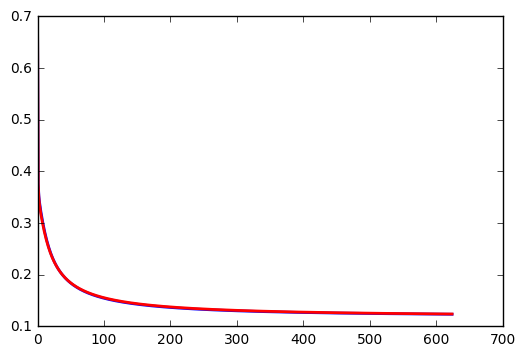

In [26]:
model.assess()
model.load_data("testing", testX, testY);
model.makeY(2);
model.assess()
model.plotLoss('training loss', 'testing loss','binaryLoss.png')

In [27]:
model.testLossSet[model.iter]

0.12360791726895808